<a href="https://colab.research.google.com/github/nayoung718/essa_python_1/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_ch4_7_229p_~_240p_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이썬 딥러닝 텐서플로 ch4.7 229p ~ 240p 필사

## 07 이미지 분할

- 이미지 분할=세그멘테이션 : 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것

-> 모든 픽셀은 어떤 클래스에 속함 : 배경 클래스와 객체 클래스로 구성된 이미지가 있으면 모든 픽셀은 배경 도는 객체 중 하나

- 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋으로 딥러닝 모델 훈련시 정답 클래스 알지 못하는 새 이미지에 대해서도 배경과 객체 분리 가능

- 이미지 분할 : 의미 분할(같은 범주의 여러 객체를 하나의 범주로 묶어서 구분) + 인스턴스 분할(같은 범주에 속하더라도 서로 다른 객체를 구분)

### 7-1 데이터셋 준비 (oxford-IIIT Pet Dataset)

- class 1: 반려동물이 속한 픽셀
- class 2: 반려동물과 인접한 픽셀
- class 3: 위와 속하지 않는 경우/주변 픽셀

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [21]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
batch_size = 16
buffer_size = 1000
epoch_num = 5
learning_rate = 0.0001

In [22]:
#텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds,info = tfds.load(name = ds_str, with_info=True)

In [23]:
#원본 이미지와 분할마스크 전처리하는 함수
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'], (img_w, img_h))
  img = tf.cast(img, tf.float32) / 255.0
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask

In [24]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

In [25]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [26]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

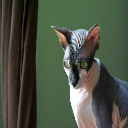

In [27]:
# 샘플 이미지 출력
img = np.array(img[0]) * 255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

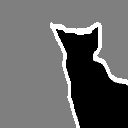

In [28]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2) * 255.0
cv2_imshow(mask)

### 7-2 U-Net 모델 (인코더-디코더)

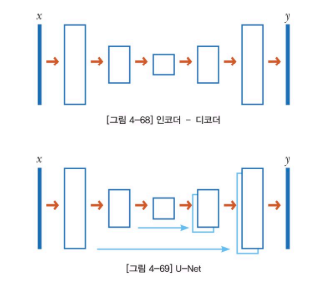

VGG16 : 이미지넷 경진대회 통해 성능 검증된 모델, 이걸 인코더로 활용하는 U-NET 모델 만들기

In [29]:
#VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape = img_shape, include_top = False)

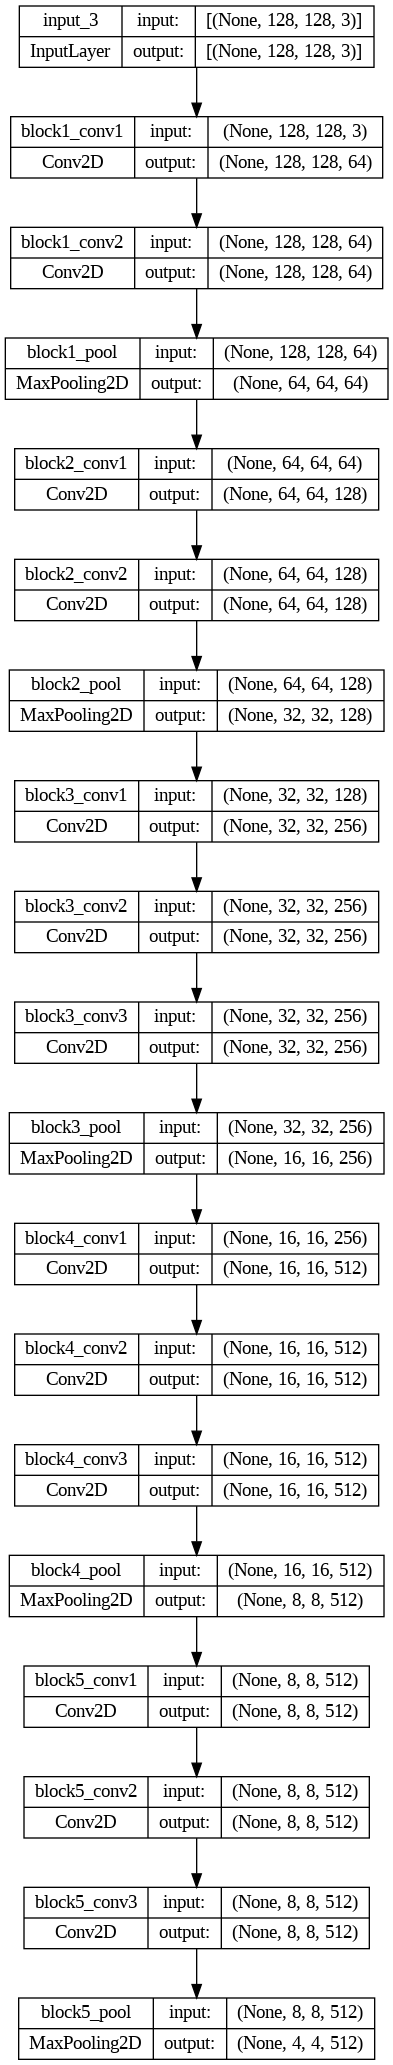

In [30]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes = True)

In [31]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs = [base_model.input],
                         outputs = [
                             base_model.get_layer('block5_conv3').output,
                             base_model.get_layer('block4_conv3').output,
                             base_model.get_layer('block3_conv3').output,
                             base_model.get_layer('block2_conv2').output,
                             base_model.get_layer('block1_conv2').output]
                         )

In [32]:
# 사전에 학습된 파라미터를 인코더에 그대로 사용
# 파라미터 고정
f_model.trainable = False

In [33]:
# 인코더 부분에서 5개의 출력을 가져와 디코더의 입력으로 전달하면서 업샘플링(축소된 이미지를 원래 이미지 크기로 복원하는 과정)

# U-Net 구조로 모델 정의

i = tf.keras.Input(shape = img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation = "elu", padding = "same")(out)
out = tf.keras.layers.Dense(3, activation = "softmax")(out)

unet_model = tf.keras.Model(inputs = [i], outputs = [out])

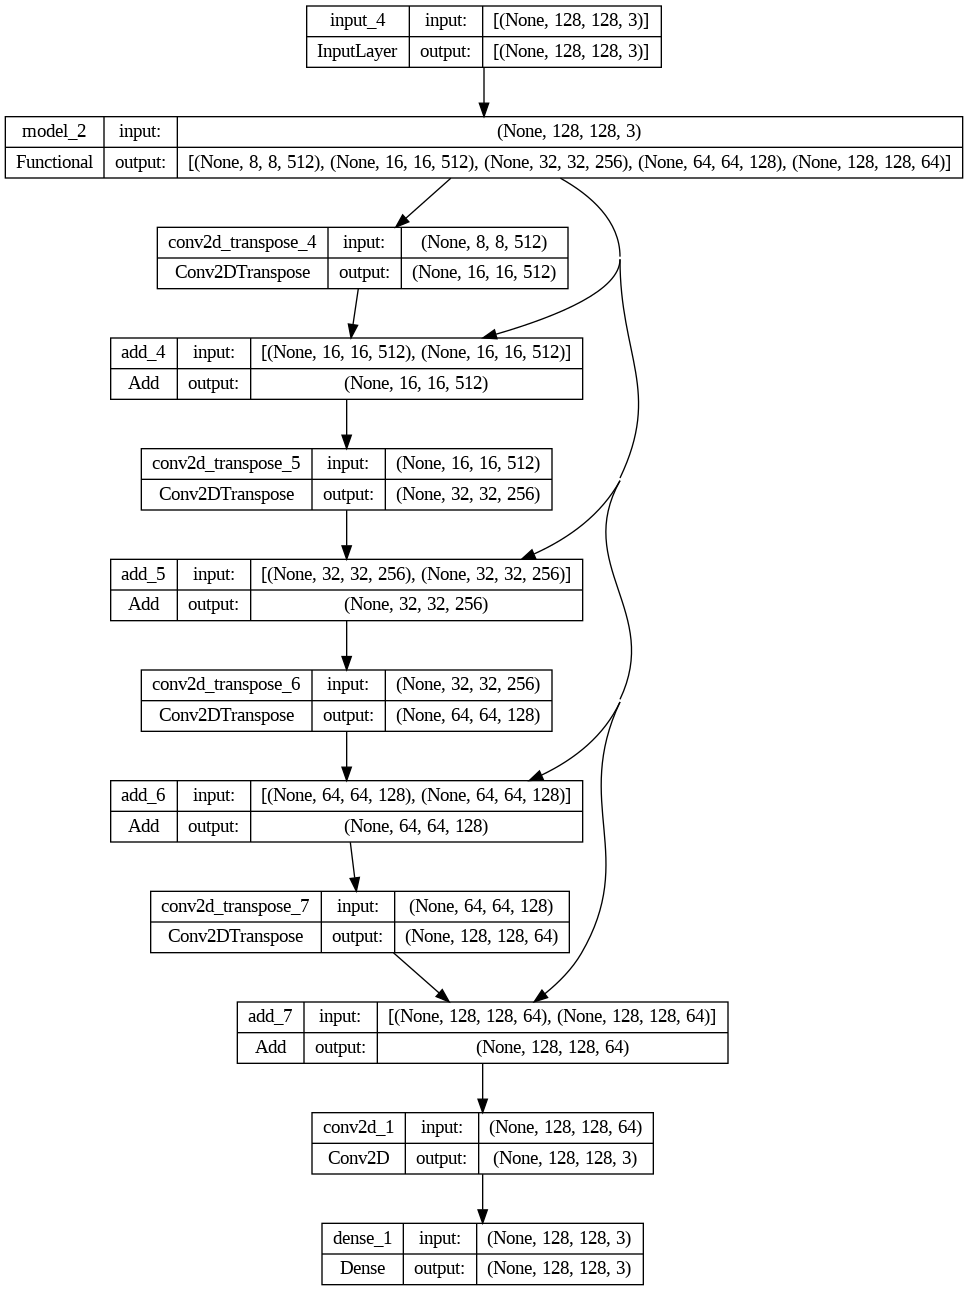

In [34]:
# unet 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes = True)

In [35]:
# 모델 요약
unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        [(None, 8, 8, 512),          1471468   ['input_4[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

In [36]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate)

unet_model.compile(loss = loss_f, optimizer = opt, metrics = ["accuracy"])
unet_model.fit(train_ds, batch_size = batch_size, epochs = epoch_num)

Epoch 1/5
230/230 [==============================] - 1368s 6s/step - loss: 0.8074 - accuracy: 0.7066
Epoch 2/5
230/230 [==============================] - 1302s 6s/step - loss: 0.5417 - accuracy: 0.7964
Epoch 3/5
230/230 [==============================] - 1331s 6s/step - loss: 0.4916 - accuracy: 0.8118
Epoch 4/5
230/230 [==============================] - 1310s 6s/step - loss: 0.4699 - accuracy: 0.8188
Epoch 5/5
230/230 [==============================] - 1321s 6s/step - loss: 0.4510 - accuracy: 0.8265


1/1 [==============================] - 4s 4s/step


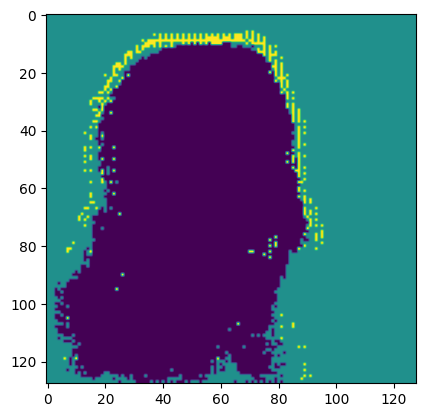

In [37]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], axis = -1)
plt.imshow(pred_img)

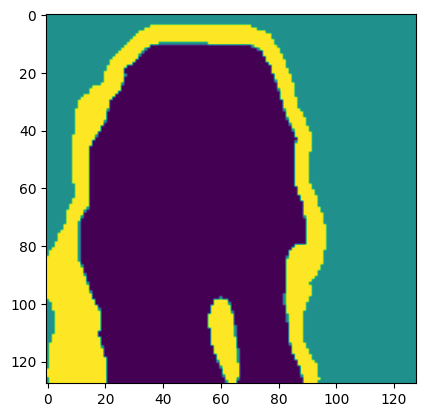

In [38]:
# 첫 번째 이미지의 정답 마스크 출력
# 정답과 예측 비교
plt.imshow(np.reshape(mask[0],(128,128)))